In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Original code from: https://github.com/debadyuti23/GraphCovidNet

In [2]:
def edge_detection():
  import numpy as np
  import cv2
  import matplotlib.pyplot as plt
  from google.colab.patches import cv2_imshow
  import glob

  #applying filter on a single image
  def apply_filter(filename,filter):
    print("reading file---> "+str(filename))
    img=cv2.imread(filename,cv2.IMREAD_GRAYSCALE)

    #img=cv2.resize(img,(250,250))
    #comment out the above line if there is memory issue i.e. need to resize all images to smaller dim

    h, w = img.shape
    print("shape: "+str(h)+" x "+str(w)+"\n")

    # define filters
    horizontal = filter
    vertical = np.transpose(filter)

    # define images with 0s
    newhorizontalImage = np.zeros((h, w))
    newverticalImage = np.zeros((h, w))
    newgradientImage = np.zeros((h, w))

    # offset by 1
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            horizontalGrad = (horizontal[0, 0] * img[i - 1, j - 1]) + \
                            (horizontal[0, 1] * img[i - 1, j]) + \
                            (horizontal[0, 2] * img[i - 1, j + 1]) + \
                            (horizontal[1, 0] * img[i, j - 1]) + \
                            (horizontal[1, 1] * img[i, j]) + \
                            (horizontal[1, 2] * img[i, j + 1]) + \
                            (horizontal[2, 0] * img[i + 1, j - 1]) + \
                            (horizontal[2, 1] * img[i + 1, j]) + \
                            (horizontal[2, 2] * img[i + 1, j + 1])

            newhorizontalImage[i - 1, j - 1] = abs(horizontalGrad)

            verticalGrad = (vertical[0, 0] * img[i - 1, j - 1]) + \
                          (vertical[0, 1] * img[i - 1, j]) + \
                          (vertical[0, 2] * img[i - 1, j + 1]) + \
                          (vertical[1, 0] * img[i, j - 1]) + \
                          (vertical[1, 1] * img[i, j]) + \
                          (vertical[1, 2] * img[i, j + 1]) + \
                          (vertical[2, 0] * img[i + 1, j - 1]) + \
                          (vertical[2, 1] * img[i + 1, j]) + \
                          (vertical[2, 2] * img[i + 1, j + 1])

            newverticalImage[i - 1, j - 1] = abs(verticalGrad)

            # Edge Magnitude
            mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
            newgradientImage[i - 1, j - 1] = mag

    return newgradientImage

  #function for creating all edge-images of a directory
  def convert_edge_dir(sourcedir,destdir):
    print("\n\n---reading directory "+sourcedir+"---\n")
    filecnt=1
    for filename in glob.glob(sourcedir+'/*'):
      #applying Prewitt filter
      #for appyling any other filter change filter value accordingly i.e. the 2nd args for apply_filter()
      imagemat=apply_filter(filename,np.array([[-1,0,1],[-1,0,1],[-1,0,1]]))
      cv2.imwrite(destdir+'/img-'+str(filecnt)+'.png',imagemat) #create the edge image and store it to consecutive filenames
      filecnt+=1
    print("\n\n--saved in "+destdir+"--\n")


  #function for creating all edge-images under covid, non-covid, penumonia directories 
  #since 4-class so COVID, NORMAL, Bacterial and Viral PNEUMONIA present
  def convert_edge_all_dir(coviddir,normdir,bacdir,virdir,destdir):
    convert_edge_dir(coviddir,destdir+'/covid')
    convert_edge_dir(normdir,destdir+'/normal')
    convert_edge_dir(bacdir,destdir+'/pneumonia_bac')
    convert_edge_dir(virdir,destdir+'/pneumonia_vir')
    print("\n---edge detection completed--\n")

  #adjust the source paths accordingly
  datasetdir='/content/drive/MyDrive/graphcovidnet/data_4_class'
  coviddir=datasetdir+'/covid'
  normdir=datasetdir+'/normal'
  bacdir=datasetdir+'/pneumonia_bac'
  virdir=datasetdir+'/pneumonia_vir'

  #adjust the destination directory accordingly
  #directory naming format--> <dataset_name(not necessary conventional)>_edge/<filtername>
  destdir='/content/drive/MyDrive/graphcovidnet/detection_4_class/' 

  convert_edge_all_dir(coviddir,normdir,bacdir,virdir,destdir)

In [3]:
#edge_detection()

In [4]:
def edge_preparation():
  import cv2
  from google.colab.patches import cv2_imshow
  import glob
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  from statistics import stdev,mean


  #define globals required through out the whole program
  edges=[] #containing all edge tuple
  attrs=[] #countaining list of attribute of all nodes
  graph_id=1 #id of latest graph
  node_id=1 #id of latest node
  graph_indicator=[] #containing graph-id for each node
  node_labels=[] #containing labels for all node
  graph_labels=[]#containing labels for all graph

  #activity-label vs activity-name mapping (4-class)
  activity_map={}
  activity_map[1]='COVID'
  activity_map[2]='NORMAL'
  activity_map[3]='PNEUMONIA_BAC'
  activity_map[4]='PNEUMONIA_VIRUS'

  #z-score normalization
  def normalize(arr):
    arr=np.array(arr)
    m=np.mean(arr)
    s=np.std(arr)
    return (arr-m)/s

  #generate graph for a given edge-image file
  def generate_graphs(filename,node_label,activity_map):
    print(" ... Reading image: "+filename+" ...")
    nonlocal node_id,edges,attrs,graph_id,node_labels,graph_indicator
    cnt=0
    img=cv2.imread(filename)
    dim1,dim2,_=img.shape
    attrs1=[]

    print("Image type: " + activity_map[node_label] + "\nPixel matrix is of: "+str(dim1)+"x"+str(dim2))
    img1=img.copy()
    nodes=np.full((dim1,dim2),-1)
    edge=0
    for i in range(dim1):
      for j in range(dim2):
        #considering pixel as node if pixel-value>=128
        b,_,_=img[i][j]
        if(b>=128):
          nodes[i][j]=node_id
          attrs1.append(b)
          graph_indicator.append(graph_id)
          node_labels.append([node_label,activity_map[node_label]])
          node_id+=1
          cnt+=1
        else:
          img1[i][j]=0
    
    for i in range(dim1):
      for j in range(dim2):
        #forming edge between all adjacent pixels which are node
        if(nodes[i][j]!=-1):
          li=max(0,i-1)
          ri=min(i+2,dim1)
          lj=max(0,j-1)
          rj=min(j+2,dim2)
          for i1 in range(li,ri):
            for j1 in range(lj,rj):
              if((i1!=i or j1!=j) and (nodes[i1][j1]!=-1)):
                edges.append([nodes[i][j],nodes[i1][j1]])
                edge+=1
    
    attrs1=normalize(attrs1)
    attrs.extend(attrs1)
    del attrs1
    print("For given image nodes formed: "+str(cnt)+" edges formed: "+str(edge))
    if(cnt!=0): graph_id+=1

  #generate graphs for all edge-image under given dir along with proper label
  def generate_graph_with_labels(dirname,label,activity_map):
    print("\n... Reading Directory: "+dirname+" ...\n")
    nonlocal graph_labels
    filenames=glob.glob(dirname+'/*.png')
    for filename in filenames:
      generate_graphs(filename,label,activity_map)
      graph_labels.append([label,activity_map[label]])

  #generate graphs for all directories
  def process_graphs(covid_dir,norm_dir,bac_dir,vir_dir,activity_map):
    nonlocal node_labels,graph_labels
    generate_graph_with_labels(covid_dir,1,activity_map)
    generate_graph_with_labels(norm_dir,2,activity_map)
    generate_graph_with_labels(bac_dir,3,activity_map)
    generate_graph_with_labels(vir_dir,4,activity_map)
    print("Processing done")
    print("Total nodes formed: "+str(len(node_labels))+"Total graphs formed: "+str(len(graph_labels)))

  #working directories
  covid_dir='/content/drive/MyDrive/graphcovidnet/detection_4_class/covid' #for covid
  norm_dir='/content/drive/MyDrive/graphcovidnet/detection_4_class/normal' #for normal
  bac_dir='/content/drive/MyDrive/graphcovidnet/detection_4_class/pneumonia_bac' #for bacterial-pneumonia
  vir_dir='/content/drive/MyDrive/graphcovidnet/detection_4_class/pneumonia_vir' #for viral-pneumonia

  
  process_graphs(covid_dir,norm_dir,bac_dir,vir_dir,activity_map)

  #check all the lengths of globals
  #comment if not necessary
  print(len(node_labels))
  print(len(graph_labels))
  print(len(edges))
  print(len(attrs))

  #create adjacency dataframe
  df_A=pd.DataFrame(columns=["node-1","node-2"],data=np.array(edges))
  print("Shape of edge dataframe: "+str(df_A.shape))
  print("\n--summary of dataframe--\n" ,df_A.head(50))

  #create node label dataframe
  df_node_label=pd.DataFrame(data=np.array(node_labels),columns=["label","activity-name"])
  print("shape of node-label dataframe: "+str(df_node_label.shape))
  print("\n--summary of dataframe--\n" ,df_node_label)

  #create graph label dataframe
  df_graph_label=pd.DataFrame(data=np.array(graph_labels),columns=["label","activity-name"])
  print("shape of node-label dataframe: "+str(df_graph_label.shape))
  print("\n--summary of dataframe--\n" ,df_graph_label.head(50))

  #create node-attribute dataframe (normalized grayscale value)
  df_node_attr=pd.DataFrame(data=np.array(attrs),columns=["gray-val"])
  print("shape of node-attribute dataframe: "+str(df_node_attr.shape))
  print("\n--summary of dataframe--\n" ,df_node_attr.head(50))

  #create graph-indicator datframe
  df_graph_indicator=pd.DataFrame(data=np.array(graph_indicator),columns=["graph-id"])
  print("shape of graph-indicator dataframe: "+str(df_graph_indicator.shape))
  print("\n--summary of dataframe--\n" ,df_graph_indicator.head(50))

  #omit activity name later for graph-label and node-label
  #since GIN model will only accept the label
  df_node_label=df_node_label.drop(["activity-name"],axis=1)
  print(df_node_label.head(50))

  df_graph_label=df_graph_label.drop(["activity-name"],axis=1)
  print(df_graph_label.head(50))



  def save_dataframe_to_txt(df,filepath):
    df.to_csv(filepath,header=None,index=None,sep=',',mode='w')



  #save all the dataframes to .txt file
  #path name: .../GraphTrain/dataset/<dataset_name>/raw/<dataset_name>_<type>.txt
  # <type>:
  # A--> adjancency matrix
  #graph_indicator--> graph-ids of all node
  #graph_labels--> labels for all graph
  #node_attributes--> attribute(s) for all node
  #node_labels--> labels for all node
  sourcepath='/content/drive/MyDrive/graphcovidnet/dataset_4_class/raw'
  save_dataframe_to_txt(df_A,sourcepath+'/A.txt')
  save_dataframe_to_txt(df_graph_indicator,sourcepath+'/graph_indicator.txt')
  save_dataframe_to_txt(df_graph_label,sourcepath+'/graph_labels.txt')
  save_dataframe_to_txt(df_node_attr,sourcepath+'/node_attributes.txt')
  save_dataframe_to_txt(df_node_label,sourcepath+'/node_labels.txt')

In [5]:
#edge_preparation()

In [8]:
!pip install tensorboardX

     |████████████████████████████████| 124 kB 8.1 MB/s 


In [6]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 10.4 MB 8.8 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 3.7 MB 6.6 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 1.6 MB 7.2 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 870 kB 2.3 MB/s 
     |████████████████████████████████| 308 kB 8.4 MB/s 
     |████████████████████████████████| 379 kB 46.7 MB/s 
     |████████████████████████████████| 45 kB 4.7 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.1-py3-none-any.whl size=513822 sha256=592dd402230d9eba27daa9ad27fae424f35dc16414fb0489bad6b56d0f8b5f47
  Stored in directory: /root/.cache/pip/wheels/78/3d/42/20589db73c66b5109fb93a0c5743edfd6ab5ca820a52afacfc
Successfully built torch

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.5), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.5
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1),F.softmax(x,dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [10]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.io import read_tu_data
import os.path as osp

class GraphDataset(InMemoryDataset):
    def __init__(self, root, name, transform=None, pre_transform=None,
                pre_filter=None, use_node_attr=False, use_edge_attr=False):
        self.name = name
        super(GraphDataset, self).__init__(root, transform, pre_transform,
                                        pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        if self.data.x is not None and not use_node_attr:
            num_node_attributes = self.num_node_attributes
            self.data.x = self.data.x[:, num_node_attributes:]
        if self.data.edge_attr is not None and not use_edge_attr:
            num_edge_attributes = self.num_edge_attributes
            self.data.edge_attr = self.data.edge_attr[:, num_edge_attributes:]

    @property
    def raw_dir(self):
        name = 'raw{}'.format('')
        return osp.join(self.root, self.name, name)

    @property
    def processed_dir(self):
        name = 'processed{}'.format('')
        return osp.join(self.root, self.name, name)

    @property
    def num_node_labels(self):
        if self.data.x is None:
            return 0
        for i in range(self.data.x.size(1)):
            x = self.data.x[:, i:]
            if ((x == 0) | (x == 1)).all() and (x.sum(dim=1) == 1).all():
                return self.data.x.size(1) - i
        return 0

    @property
    def num_node_attributes(self):
        if self.data.x is None:
            return 0
        return self.data.x.size(1) - self.num_node_labels

    @property
    def num_edge_labels(self):
        if self.data.edge_attr is None:
            return 0
        for i in range(self.data.edge_attr.size(1)):
            if self.data.edge_attr[:, i:].sum() == self.data.edge_attr.size(0):
                return self.data.edge_attr.size(1) - i
        return 0

    @property
    def num_edge_attributes(self):
        if self.data.edge_attr is None:
            return 0
        return self.data.edge_attr.size(1) - self.num_edge_labels

    @property
    def raw_file_names(self):
        names = ['A', 'graph_indicator','graph_labels','node_attributes','node_labels']
        return ['{}.txt'.format(name) for name in names]

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        self.data, self.slices = read_tu_data(self.raw_dir, self.name)

        if self.pre_filter is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [data for data in data_list if self.pre_filter(data)]
            self.data, self.slices = self.collate(data_list)

        if self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [self.pre_transform(data) for data in data_list]
            self.data, self.slices = self.collate(data_list)

        torch.save((self.data, self.slices), self.processed_paths[0])

    def __repr__(self):
        return '{}({})'.format('dataset_repr', len(self))

In [11]:
  import time
  import random
  import sys
  import numpy as np
  import torch
  import argparse
  import torch.nn.functional as F
  import matplotlib.pyplot as plt
  from statistics import mean, pstdev
  import torch.nn.functional as F

  import seaborn as sns

  from sklearn.metrics import f1_score, precision_score, recall_score,roc_curve,auc,classification_report,confusion_matrix

  from tensorflow.keras.utils import to_categorical

  #printing confusion matrix
  def show_confusion_matrix(validations, predictions):
    
      LABELS=["COVID","NON-COVID","PNEUMONIA"]
      matrix = confusion_matrix(validations, predictions)
      print(matrix)
      

In [17]:
def main_fn():

  # Training settings
  parser = argparse.ArgumentParser()
  parser.add_argument('cuda', action='store_true', default=True,
                      help='Use CUDA for training.')
  parser.add_argument('--seed', type=int, default=43, help='Random seed.')
  parser.add_argument('--epochs', type=int, default=200,
                      help='Number of epochs to train.')
  parser.add_argument('--lr', type=float, default=0.01,
                      help='Initial learning rate.')
  parser.add_argument('--weight_decay', type=float, default=5e-4,
                      help='Weight decay for optimizer.')
  parser.add_argument('--hidden', type=int, default=16,
                      help='Number of hidden units.')
  parser.add_argument('--dropout', type=float, default=0.5,
                      help='Dropout rate (1 - keep probability).')
  parser.add_argument('--train_split', type=float, default=0.8,
                      help='Ratio of train split from entire dataset.Rest goes to test set')
  parser.add_argument('--batch_size', type=int, default=16,
                      help='batch size for loading mini batches of data')
  parser.add_argument('--dataset_name', type=str, default='dataset_4_class',
                      help='Dataset name')
  # args = {}
  # args['cuda'] = True
  # args['seed'] = 42
  # args['epochs'] = 200
  # args['lr'] = 0.01
  # args['weight_decay'] = 5e-4
  # args['hidden'] = 16
  # args['dropout'] = 0.5
  # args['train_split'] = 0.8
  # args['batch_size'] = 16
  # args['dataset_name'] = 'dataset_test'
  args = parser.parse_args(['--epochs', '1'])
  if args.cuda:
    if torch.cuda.is_available():
      device = torch.device('cuda')
      torch.cuda.manual_seed(args.seed)
    else:
      print("Sorry no gpu found!!")
      device=torch.device('cpu')
      print("Running model on cpu")
  else:
    device=torch.device('cpu')

  #Setting seed to reproduce results
  random.seed(args.seed)
  np.random.seed(args.seed)
  torch.manual_seed(args.seed)

  dataset = GraphDataset(root='/content/drive/My Drive/graphcovidnet/', name=args.dataset_name, use_node_attr=True)
  data_size = len(dataset)

  #checking some of the data attributes comment out these lines if not needed to check
  print("*"*10)
  print(data_size)
  print(dataset.num_features)
  print(args.hidden)
  print(args.dropout)
  print(dataset.num_classes)
  print("*"*10)

  n_classes=dataset.num_classes
  class_list=[]
  for i in range(0,n_classes):
      class_list.append(i)


  #applying k-fold cross validation
  def crossvalid(dataset=None,k_fold=5):
      nonlocal precision,recall,f1
      
      total_size = len(dataset)
      fraction = 1/k_fold
      seg = int(total_size * fraction) 
      index=0
      test_accs=[]
      train_time=0
      test_time=0
      for i in range(k_fold):
          if(i==k_fold-1):
              print("Running for {} fold".format(index+1))
              index=index+1
              trll = 0
              trlr = i * seg
              vall = trlr
              valr = i * seg + seg
              trrl = valr
              trrr = total_size
              
              train_left_indices = list(range(trll,trlr))
              train_right_indices = list(range(trrl,trrr))
              
              train_indices = train_left_indices + train_right_indices
              val_indices = list(range(vall,valr))
              
              train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
              val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
              
              print(len(train_set),len(val_set))
              
              train_loader = DataLoader(train_set, batch_size=1,
                                                shuffle=True)
              val_loader = DataLoader(val_set, batch_size=1,
                                                shuffle=True)
                                                
              
              model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
              opt = optim.Adam(model.parameters(), lr=0.001)
              
              loss_values=[]
              accuracy_values=[]
              
              train_start=time.time()  
              for epoch in range(1):
                total_loss = 0
                model.train()
                for batch in train_loader:
                  
                  opt.zero_grad()
                  embedding, pred, soft= model(batch)
                  label = batch.y
                  if task == 'node':
                      pred = pred[batch.train_mask]
                      label = label[batch.train_mask]
                  loss = model.loss(pred, label)
                  loss.backward()
                  opt.step()
                  total_loss += loss.item() * batch.num_graphs
                total_loss /= len(train_loader.dataset)
                writer.add_scalar("loss", total_loss, epoch)
      
                if epoch % 1 == 0:
                  train_acc = test(train_loader, model)
                  print("Epoch {}. Train Loss: {:.4f}. Train accuracy: {:.4f}".format(
                      epoch, total_loss, train_acc))
                      
                  loss_values.append(total_loss)
                  accuracy_values.append(train_acc)
                  
                  writer.add_scalar("train accuracy", train_acc, epoch)
              
              train_end=time.time()
              print("Time taken for training: ",train_end-train_start)
              train_time+=(train_end-train_start)
              
              test_start=time.time()
              test_acc = test(val_loader, model, True)
              test_end=time.time()
              print("Test accuracy: {:.4f}".format(test_acc))
              print("Time taken for testing: ",test_end-test_start)
              test_time+=(test_end-test_start)
              
              fig = plt.figure(figsize=(5,5))
              ax = fig.add_subplot(111)
              ax.set_title('Training loss and accuracy Vs Epoch')
              plt.plot(loss_values, color='red',label='Loss')
              plt.plot(accuracy_values, color='blue',label='Accuracy')
              ax.set_xlabel('Epoch')
              ax.set_ylabel('Loss and Accuracy')
              ax.legend(loc='best')
              plt.savefig(f"{k_fold}-fold_"+args.dataset_name+"_"+str(i+1)+".png")
              
              test_accs.append(test_acc)
                  
      precision/=k_fold
      recall/=k_fold
      f1/=k_fold
      avg_test=sum(test_accs)/len(test_accs)
      train_time/=k_fold
      test_time/=k_fold
      print("------------")
      print("{} fold test accuracy {:.4f}, precision {:.4f}, recall {:.4f}, F1-score {:.4f}".format(k_fold,avg_test,precision,recall,f1))
      print("Average training time {:.3f}, average testing time {:.3f}".format(train_time,test_time))    


  def train(dataset, task, writer):
      crossvalid(dataset)
      
  #function for calculating acc for different train-ratio
  def eval_train_ratio(dataset, task, writer):
      
      train_ratios=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

      test_accuracies=[]
      train_accuracies=[]
      for tr in train_ratios:
          if task == 'graph':
              data_size = len(dataset)
              train_loader = DataLoader(dataset[:int(data_size * tr)], batch_size=1, shuffle=True)
              test_loader = DataLoader(dataset[int(data_size * tr):], batch_size=1, shuffle=True)
          else:
              test_loader = train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
      
          print("Train ratio: {:.1f}. No of training graphs: {}. No of testing graphs: {}".format(tr,len(train_loader),len(test_loader)))
          
          model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
          model.to(device)
          opt = optim.Adam(model.parameters(), lr=0.001)

          for epoch in range(args.epochs):
            total_loss = 0
            model.train()
            for batch in train_loader:
              batch.to(device)
              
              opt.zero_grad()
              embedding, pred ,_= model(batch)
              label = batch.y
              if task == 'node':
                  pred = pred[batch.train_mask]
                  label = label[batch.train_mask]
              loss = model.loss(pred, label)
              loss.backward()
              opt.step()
              total_loss += loss.item() * batch.num_graphs
            total_loss /= len(train_loader.dataset)
            
          
          model.to('cpu')

          train_acc = test(train_loader, model)
          test_acc = test(test_loader, model, True)
          print("Test accuracy: {:.4f}".format(test_acc))
          test_accuracies.append(test_acc)
          train_accuracies.append(train_acc)
          
      fig = plt.figure(figsize=(7,7))
      ax = fig.add_subplot(111)
      ax.set_title('Training and testing accuracy Vs Train Ratio')
      plt.plot(train_ratios, train_accuracies, color='red', marker= 'o',label='Train Acc')
      plt.plot(train_ratios, test_accuracies, color='blue',marker= 'o', label='Test Acc')
      ax.set_xlabel('Train Ratio')
      ax.set_ylabel('Training and testing accuracy')
      ax.legend(loc='best')
      #plt.show()
      plt.savefig(f"iterative_training_"+args.dataset_name+".png")
      
  def test(loader, model, is_test=False,is_validation=False):
      nonlocal precision,recall,f1
      nonlocal class_list,n_classes
      nonlocal cnt
      model.eval()
      
      correct = 0
      glabel=[]
      glabel1=[]
      gpred=[]
      gscore=[]
      for data in loader:
          with torch.no_grad():
              emb, pred,soft = model(data)
              var=soft.numpy()[0]
              pred = pred.argmax(dim=1)
              label = data.y
              
              
              if(is_test): 
                  glabel.append(label.numpy()[0])
                  glabel1.append(label.numpy())   
                  gpred.append(pred.numpy()[0])
                  gscore.append(var)
              

          if model.task == 'node':
              mask = data.val_mask if is_validation else data.test_mask
              pred = pred[mask]
              label = data.y[mask]
              
          correct += pred.eq(label).sum().item()
      
      if model.task == 'graph':
          total = len(loader.dataset) 
      else:
          total = 0
          for data in loader.dataset:
              total += torch.sum(data.test_mask).item()
      
      if(is_test):
          glabel=np.array(glabel)
          glabel1=np.array(glabel1)
          gpred=np.array(gpred)
          gscore=np.array(gscore)
          enlabel=to_categorical(glabel1,n_classes)
          
          
          
          p=precision_score(glabel, gpred, average="micro")
          r=recall_score(glabel, gpred, average="micro")
          f=f1_score(glabel, gpred, average="micro")
          
          print('F1: {}'.format(f))
          print('Precision: {}'.format(p))
          print('Recall: {}'.format(r))
          precision+=p
          recall+=r
          f1+=f
          
          print("\n...confusion matrix and classification report....\n")
          show_confusion_matrix(glabel,gpred)
          print(classification_report(glabel,gpred))

          
          #generate roc curve
          tpr=dict()
          fpr=dict()
          roc_auc=dict()
          for i in range(n_classes):
              fpr[i], tpr[i], _= roc_curve(enlabel[:, i], gscore[:, i])
              roc_auc[i] = auc(fpr[i], tpr[i])
          fig = plt.figure(figsize=(5,5))
          ax = fig.add_subplot(111)
          ax.set_title('ROC curve for all classes')
          colors=['red','blue','green','yellow','purple','orange']
          for i in range(n_classes):
              plt.plot(fpr[i], tpr[i], color=colors[i],lw=2,label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))    
          ax.set_xlabel('False postive rate')
          ax.set_ylabel('True postive rate')
          ax.legend(loc='best')
          plt.savefig(f"roc_"+args.dataset_name+"_"+str(cnt)+".png")
          cnt+=1
          
      return correct / total
  dataset = dataset.shuffle()
  task = 'graph'
  writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

  #globals 
  precision=0
  recall=0
  f1=0

  cnt=1

  #train(dataset, task, writer)
  eval_train_ratio(dataset, task, writer)

**********
304
5
16
0.5
4
**********
Train ratio: 0.1. No of training graphs: 30. No of testing graphs: 274


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 0.72992700729927
Precision: 0.7299270072992701
Recall: 0.7299270072992701

...confusion matrix and classification report....

[[59  0  0  0]
 [73  0  0  0]
 [ 0  0 71  1]
 [ 0  0  0 70]]
              precision    recall  f1-score   support

           0       0.45      1.00      0.62        59
           1       0.00      0.00      0.00        73
           2       1.00      0.99      0.99        72
           3       0.99      1.00      0.99        70

    accuracy                           0.73       274
   macro avg       0.61      0.75      0.65       274
weighted avg       0.61      0.73      0.65       274

Test accuracy: 0.7299
Train ratio: 0.2. No of training graphs: 60. No of testing graphs: 244


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 0.9959016393442623
Precision: 0.9959016393442623
Recall: 0.9959016393442623

...confusion matrix and classification report....

[[50  0  0  0]
 [ 0 62  0  0]
 [ 0  0 64  1]
 [ 0  0  0 67]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        62
           2       1.00      0.98      0.99        65
           3       0.99      1.00      0.99        67

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244

Test accuracy: 0.9959
Train ratio: 0.3. No of training graphs: 91. No of testing graphs: 213


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 0.9953051643192489
Precision: 0.9953051643192489
Recall: 0.9953051643192489

...confusion matrix and classification report....

[[45  0  0  0]
 [ 0 52  0  0]
 [ 0  0 57  1]
 [ 0  0  0 58]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        52
           2       1.00      0.98      0.99        58
           3       0.98      1.00      0.99        58

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

Test accuracy: 0.9953
Train ratio: 0.4. No of training graphs: 121. No of testing graphs: 183


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 0.994535519125683
Precision: 0.994535519125683
Recall: 0.994535519125683

...confusion matrix and classification report....

[[38  0  0  0]
 [ 0 47  0  0]
 [ 0  0 48  1]
 [ 0  0  0 49]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        47
           2       1.00      0.98      0.99        49
           3       0.98      1.00      0.99        49

    accuracy                           0.99       183
   macro avg       0.99      0.99      0.99       183
weighted avg       0.99      0.99      0.99       183

Test accuracy: 0.9945
Train ratio: 0.5. No of training graphs: 152. No of testing graphs: 152


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[32  0  0  0]
 [ 0 39  0  0]
 [ 0  0 41  0]
 [ 0  0  0 40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        39
           2       1.00      1.00      1.00        41
           3       1.00      1.00      1.00        40

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152

Test accuracy: 1.0000
Train ratio: 0.6. No of training graphs: 182. No of testing graphs: 122


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[27  0  0  0]
 [ 0 32  0  0]
 [ 0  0 32  0]
 [ 0  0  0 31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00        32
           3       1.00      1.00      1.00        31

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122

Test accuracy: 1.0000
Train ratio: 0.7. No of training graphs: 212. No of testing graphs: 92


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[20  0  0  0]
 [ 0 25  0  0]
 [ 0  0 24  0]
 [ 0  0  0 23]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        23

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92

Test accuracy: 1.0000
Train ratio: 0.8. No of training graphs: 243. No of testing graphs: 61


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[17  0  0  0]
 [ 0 19  0  0]
 [ 0  0 13  0]
 [ 0  0  0 12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        12

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61

Test accuracy: 1.0000
Train ratio: 0.9. No of training graphs: 273. No of testing graphs: 31


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[ 6  0  0  0]
 [ 0 12  0  0]
 [ 0  0  6  0]
 [ 0  0  0  7]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         7

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Test accuracy: 1.0000


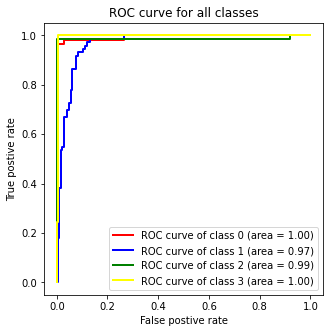

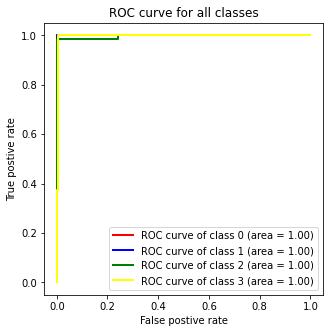

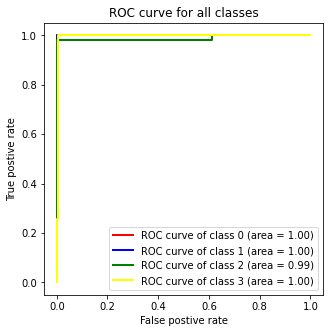

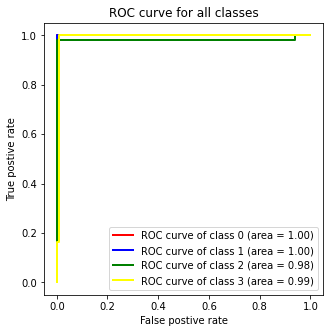

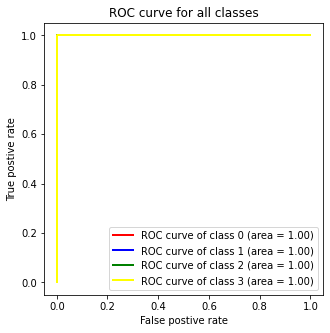

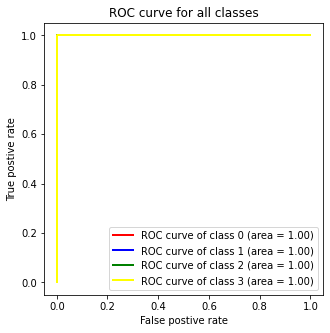

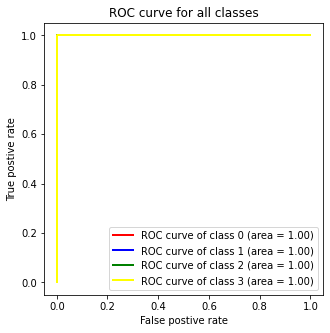

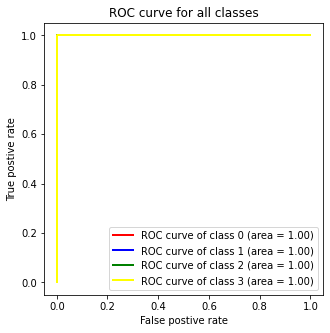

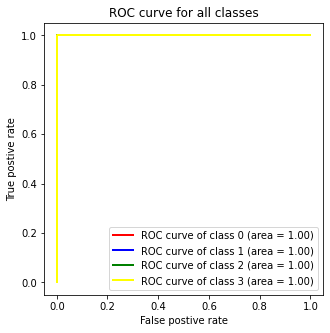

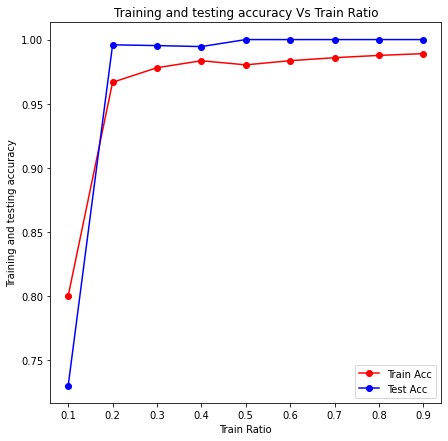

In [18]:
main_fn()

In [19]:
from collections import OrderedDict

def update_client(federated_model, client):
    client.load_state_dict(federated_model.state_dict(), True)
    return client
    
def federated_average(federated_model, client_models):
    average_weights = OrderedDict()

    number_of_clients = len(client_models)
    for client_model in client_models:
        for key, value in client_model.state_dict().items():
            if key in average_weights:
                average_weights[key] += (1./number_of_clients) * value.clone()
            else:
                average_weights[key] = (1./number_of_clients) * value.clone()
                
                
    federated_model.load_state_dict(average_weights, True)
    return federated_model

In [20]:
def main_fn_federated():
  # Training settings
  parser = argparse.ArgumentParser()
  parser.add_argument('cuda', action='store_true', default=True,
                      help='Use CUDA for training.')
  parser.add_argument('--seed', type=int, default=42, help='Random seed.')
  parser.add_argument('--epochs', type=int, default=200,
                      help='Number of epochs to train.')
  parser.add_argument('--lr', type=float, default=0.01,
                      help='Initial learning rate.')
  parser.add_argument('--weight_decay', type=float, default=5e-4,
                      help='Weight decay for optimizer.')
  parser.add_argument('--hidden', type=int, default=16,
                      help='Number of hidden units.')
  parser.add_argument('--dropout', type=float, default=0.5,
                      help='Dropout rate (1 - keep probability).')
  parser.add_argument('--train_split', type=float, default=0.8,
                      help='Ratio of train split from entire dataset.Rest goes to test set')
  parser.add_argument('--batch_size', type=int, default=16,
                      help='batch size for loading mini batches of data')
  parser.add_argument('--dataset_name', type=str, default='dataset_4_class',
                      help='Dataset name')

  args = parser.parse_args(['--epochs', '1'])
  if args.cuda:
    if torch.cuda.is_available():
      device = torch.device('cuda')
      torch.cuda.manual_seed(args.seed)
    else:
      print("Sorry no gpu found!!")
      device=torch.device('cpu')
      print("Running model on cpu")
  else:
    device=torch.device('cpu')

  #Setting seed to reproduce results
  random.seed(args.seed)
  np.random.seed(args.seed)
  torch.manual_seed(args.seed)

  #function for calculating acc for different train-ratio
  def eval_train_ratio(dataset):
      nonlocal no_of_clients

      train_ratios=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

      test_accuracies=[]
      train_accuracies=[]

      data_size_overall = len(dataset)

      for train_ratio in train_ratios:
          federated_model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task='graph')

          data_size_train = int(data_size_overall * train_ratio)
          data_size_test = data_size_overall - data_size_train

          dataset_size_per_client = data_size_train // no_of_clients # train data is split to clients
          indices_clients = np.random.permutation(np.arange(dataset_size_per_client * no_of_clients)) 

          dataset_train = torch.utils.data.Subset(dataset, range(data_size_train))

          train_loaders = []
          for idx in range(no_of_clients):
              client_subset = torch.utils.data.Subset(dataset_train, indices_clients[idx*dataset_size_per_client:(idx+1)*dataset_size_per_client])
              train_loaders += [DataLoader(client_subset, batch_size=1, shuffle=True)]
          
          test_loader = DataLoader(dataset[int(data_size * train_ratio):], batch_size=1, shuffle=True)
      
          print("Train ratio: {:.1f}. No of training graphs: {} ({} per client). No of testing graphs: {}".format(train_ratio, data_size_train, dataset_size_per_client, len(test_loader)))
          
          client_models = [GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task='graph') for _ in range(no_of_clients)]

          for epoch in range(args.epochs):
            for client_idx in range(no_of_clients):
              print(f"+++ FEDERATED MODEL {client_idx}, EPOCH: {epoch+1} +++++++++")

              client_model = client_models[client_idx]
              client_model.to(device)
              client_model = update_client(federated_model, client_model)

              client_opt = optim.Adam(client_model.parameters(), lr=0.001)

              client_train_loader = train_loaders[client_idx]

              total_loss = 0
              client_model.train()

              for batch in client_train_loader:
                batch.to(device)

                client_opt.zero_grad()
                embedding, pred ,_ = client_model(batch)
                label = batch.y
  
                loss = client_model.loss(pred, label)
                loss.backward()
                client_opt.step()

                total_loss += loss.item() * batch.num_graphs
              total_loss /= len(client_train_loader.dataset)

              client_model.to('cpu')

            federated_model = federated_average(federated_model, client_models)
          
          overall_train_loader = DataLoader(dataset[:int(data_size * train_ratio)], batch_size=1, shuffle=True)
          train_acc = test(overall_train_loader, federated_model)
          test_acc = test(test_loader, federated_model, True)
          print("Test accuracy: {:.4f}".format(test_acc))
          test_accuracies.append(test_acc)
          train_accuracies.append(train_acc)
          
      fig = plt.figure(figsize=(7,7))
      ax = fig.add_subplot(111)
      ax.set_title('Training and testing accuracy Vs Train Ratio')
      plt.plot(train_ratios, train_accuracies, color='red', marker= 'o',label='Train Acc')
      plt.plot(train_ratios, test_accuracies, color='blue',marker= 'o', label='Test Acc')
      ax.set_xlabel('Train Ratio')
      ax.set_ylabel('Training and testing accuracy')
      ax.legend(loc='best')
      #plt.show()
      plt.savefig(f"iterative_training_"+args.dataset_name+".png")
      
  def test(loader, model, is_test=False,is_validation=False):
      nonlocal precision, recall, f1
      nonlocal n_classes, cnt

      model.eval()
      
      correct = 0
      glabel=[]
      glabel1=[]
      gpred=[]
      gscore=[]
      for data in loader:
          with torch.no_grad():
              emb, pred,soft = model(data)
              var=soft.numpy()[0]
              pred = pred.argmax(dim=1)
              label = data.y
              
              
              if(is_test): 
                  glabel.append(label.numpy()[0])
                  glabel1.append(label.numpy())   
                  gpred.append(pred.numpy()[0])
                  gscore.append(var)
              
          correct += pred.eq(label).sum().item()
      
      
      total = len(loader.dataset) 
      
      if(is_test):
          glabel=np.array(glabel)
          glabel1=np.array(glabel1)
          gpred=np.array(gpred)
          gscore=np.array(gscore)
          enlabel=to_categorical(glabel1,n_classes)
          
          
          
          p=precision_score(glabel, gpred, average="micro")
          r=recall_score(glabel, gpred, average="micro")
          f=f1_score(glabel, gpred, average="micro")
          
          print('F1: {}'.format(f))
          print('Precision: {}'.format(p))
          print('Recall: {}'.format(r))
          precision+=p
          recall+=r
          f1+=f
          
          print("\n...confusion matrix and classification report....\n")
          show_confusion_matrix(glabel,gpred)
          print(classification_report(glabel,gpred))

          
          #generate roc curve
          tpr=dict()
          fpr=dict()
          roc_auc=dict()
          for i in range(n_classes):
              fpr[i], tpr[i], _= roc_curve(enlabel[:, i], gscore[:, i])
              roc_auc[i] = auc(fpr[i], tpr[i])
          fig = plt.figure(figsize=(5,5))
          ax = fig.add_subplot(111)
          ax.set_title('ROC curve for all classes')
          colors=['red','blue','green','yellow','purple','orange']
          for i in range(n_classes):
              plt.plot(fpr[i], tpr[i], color=colors[i],lw=2,label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))    
          ax.set_xlabel('False postive rate')
          ax.set_ylabel('True postive rate')
          ax.legend(loc='best')
          plt.savefig(f"roc_"+args.dataset_name+"_"+str(cnt)+".png")
          cnt+=1
          
      return correct / total

  no_of_clients = 4
    
  dataset = GraphDataset(root='/content/drive/My Drive/graphcovidnet/', name=args.dataset_name, use_node_attr=True)
  data_size = len(dataset)

  n_classes = dataset.num_classes

  dataset = dataset.shuffle()

  # globals
  precision = 0
  recall = 0
  f1 = 0
  cnt = 1

  eval_train_ratio(dataset)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Train ratio: 0.1. No of training graphs: 30 (7 per client). No of testing graphs: 274
+++ FEDERATED MODEL 0, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 1, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 1 +++++++++
F1: 0.22992700729927007
Precision: 0.22992700729927007
Recall: 0.22992700729927007

...confusion matrix and classification report....

[[ 0  0  0 67]
 [ 0  0  0 69]
 [ 0  0  0 75]
 [ 0  0  0 63]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.00      0.00      0.00        69
           2       0.00      0.00      0.00        75
           3       0.23      1.00      0.37        63

    accuracy                           0.23       274
   macro avg       0.06      0.25      0.09       274
weighted avg       0.05      0.23      0.09       274

Test accuracy: 0.2299
Train ratio: 0.2. No of training graphs: 60 (15 per client). No of testing graphs: 244
+++ FE

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


+++ FEDERATED MODEL 1, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 1 +++++++++
F1: 0.7213114754098362
Precision: 0.7213114754098361
Recall: 0.7213114754098361

...confusion matrix and classification report....

[[ 0  1 59  0]
 [ 0 60  1  0]
 [ 0  0 64  1]
 [ 0  5  1 52]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.91      0.98      0.94        61
           2       0.51      0.98      0.67        65
           3       0.98      0.90      0.94        58

    accuracy                           0.72       244
   macro avg       0.60      0.72      0.64       244
weighted avg       0.60      0.72      0.64       244

Test accuracy: 0.7213
Train ratio: 0.3. No of training graphs: 91 (22 per client). No of testing graphs: 213
+++ FEDERATED MODEL 0, EPOCH: 1 +++++++++


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


+++ FEDERATED MODEL 1, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 1 +++++++++
F1: 0.676056338028169
Precision: 0.676056338028169
Recall: 0.676056338028169

...confusion matrix and classification report....

[[18  0 34  0]
 [ 0 40 17  0]
 [ 0  0 56  0]
 [ 0  0 18 30]]
              precision    recall  f1-score   support

           0       1.00      0.35      0.51        52
           1       1.00      0.70      0.82        57
           2       0.45      1.00      0.62        56
           3       1.00      0.62      0.77        48

    accuracy                           0.68       213
   macro avg       0.86      0.67      0.68       213
weighted avg       0.85      0.68      0.68       213

Test accuracy: 0.6761
Train ratio: 0.4. No of training graphs: 121 (30 per client). No of testing graphs: 183
+++ FEDERATED MODEL 0, EPOCH: 1 +++++++++


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


+++ FEDERATED MODEL 1, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 1 +++++++++
F1: 0.5573770491803278
Precision: 0.5573770491803278
Recall: 0.5573770491803278

...confusion matrix and classification report....

[[26  0 10 10]
 [ 0  5  1 47]
 [ 0  0 31 13]
 [ 0  0  0 40]]
              precision    recall  f1-score   support

           0       1.00      0.57      0.72        46
           1       1.00      0.09      0.17        53
           2       0.74      0.70      0.72        44
           3       0.36      1.00      0.53        40

    accuracy                           0.56       183
   macro avg       0.78      0.59      0.54       183
weighted avg       0.80      0.56      0.52       183

Test accuracy: 0.5574
Train ratio: 0.5. No of training graphs: 152 (38 per client). No of testing graphs: 152
+++ FEDERATED MODEL 0, EPOCH: 1 +++++++++


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


+++ FEDERATED MODEL 1, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 1 +++++++++
F1: 0.6842105263157895
Precision: 0.6842105263157895
Recall: 0.6842105263157895

...confusion matrix and classification report....

[[36  0  0  0]
 [ 1  0 47  0]
 [ 0  0 34  0]
 [ 0  0  0 34]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       0.00      0.00      0.00        48
           2       0.42      1.00      0.59        34
           3       1.00      1.00      1.00        34

    accuracy                           0.68       152
   macro avg       0.60      0.75      0.64       152
weighted avg       0.55      0.68      0.59       152

Test accuracy: 0.6842
Train ratio: 0.6. No of training graphs: 182 (45 per client). No of testing graphs: 122
+++ FEDERATED MODEL 0, EPOCH: 1 +++++++++


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


+++ FEDERATED MODEL 1, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 1 +++++++++
F1: 0.9918032786885246
Precision: 0.9918032786885246
Recall: 0.9918032786885246

...confusion matrix and classification report....

[[25  0  0  0]
 [ 0 40  1  0]
 [ 0  0 29  0]
 [ 0  0  0 27]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      0.98      0.99        41
           2       0.97      1.00      0.98        29
           3       1.00      1.00      1.00        27

    accuracy                           0.99       122
   macro avg       0.99      0.99      0.99       122
weighted avg       0.99      0.99      0.99       122

Test accuracy: 0.9918
Train ratio: 0.7. No of training graphs: 212 (53 per client). No of testing graphs: 92
+++ FEDERATED MODEL 0, EPOCH: 1 +++++++++


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


+++ FEDERATED MODEL 1, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 1 +++++++++
F1: 0.9891304347826086
Precision: 0.9891304347826086
Recall: 0.9891304347826086

...confusion matrix and classification report....

[[22  0  0  0]
 [ 0 29  1  0]
 [ 0  0 18  0]
 [ 0  0  0 22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      0.97      0.98        30
           2       0.95      1.00      0.97        18
           3       1.00      1.00      1.00        22

    accuracy                           0.99        92
   macro avg       0.99      0.99      0.99        92
weighted avg       0.99      0.99      0.99        92

Test accuracy: 0.9891
Train ratio: 0.8. No of training graphs: 243 (60 per client). No of testing graphs: 61
+++ FEDERATED MODEL 0, EPOCH: 1 +++++++++


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


+++ FEDERATED MODEL 1, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 1 +++++++++
F1: 0.9836065573770492
Precision: 0.9836065573770492
Recall: 0.9836065573770492

...confusion matrix and classification report....

[[15  0  0  0]
 [ 0 20  1  0]
 [ 0  0 13  0]
 [ 0  0  0 12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.95      0.98        21
           2       0.93      1.00      0.96        13
           3       1.00      1.00      1.00        12

    accuracy                           0.98        61
   macro avg       0.98      0.99      0.98        61
weighted avg       0.98      0.98      0.98        61

Test accuracy: 0.9836
Train ratio: 0.9. No of training graphs: 273 (68 per client). No of testing graphs: 31
+++ FEDERATED MODEL 0, EPOCH: 1 +++++++++


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


+++ FEDERATED MODEL 1, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 1 +++++++++
F1: 1.0
Precision: 1.0
Recall: 1.0

...confusion matrix and classification report....

[[ 7  0  0  0]
 [ 0 10  0  0]
 [ 0  0  6  0]
 [ 0  0  0  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         8

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Test accuracy: 1.0000


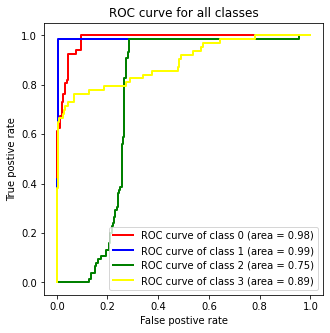

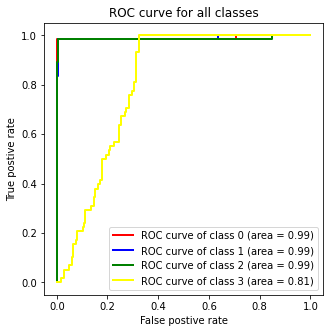

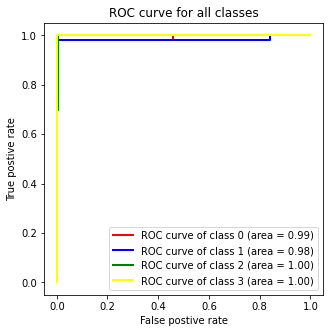

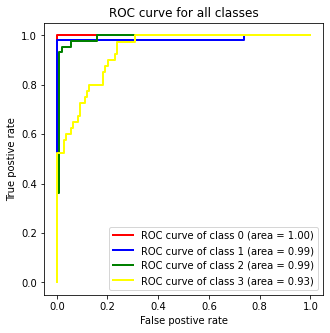

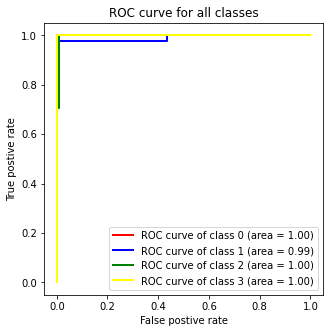

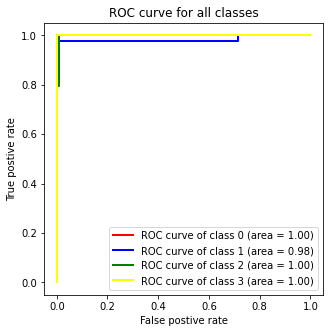

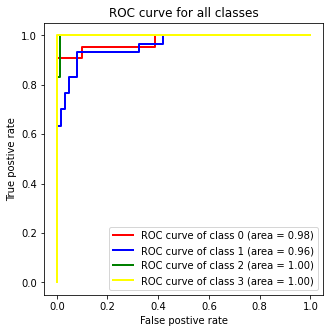

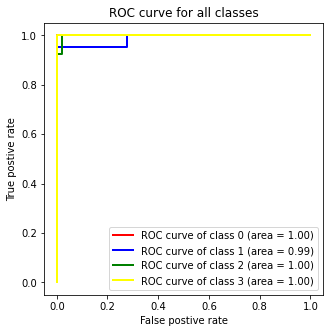

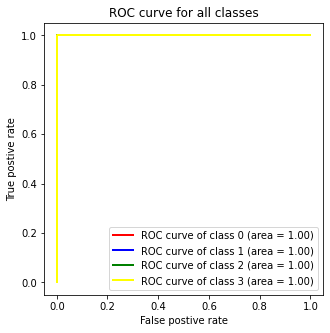

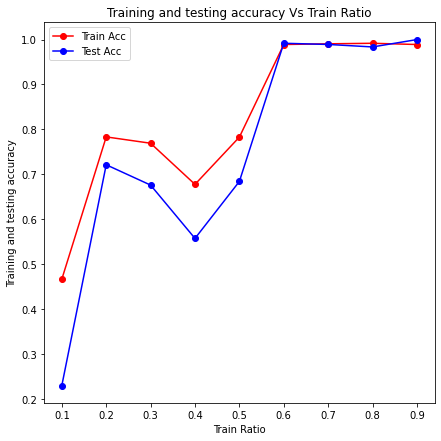

In [21]:
main_fn_federated()